# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import pdb

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

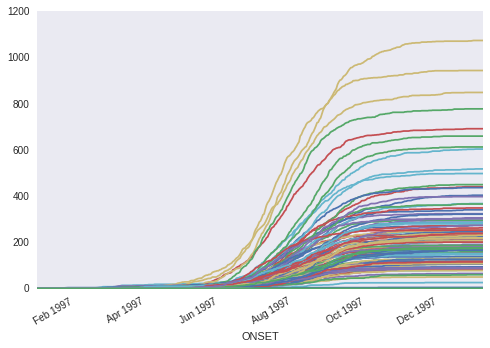

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [9]:
total_district_cases = measles_onset_dist.sum()

Top 5 districts by number of cases

In [10]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

Age distribution of cases, by confirmation status

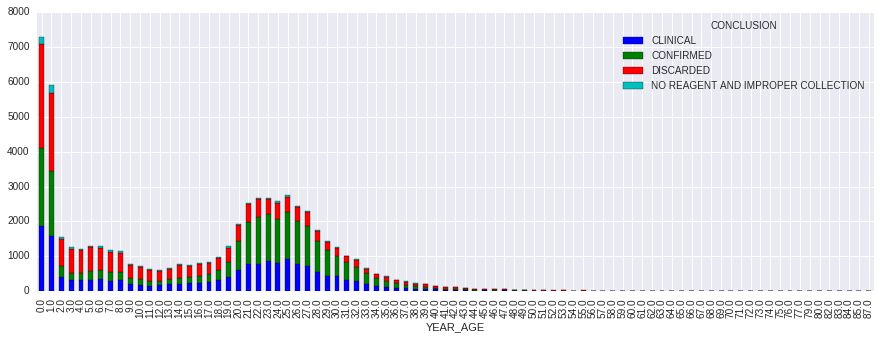

In [11]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

### Vaccination Data

In [12]:
vaccination_data = pd.read_csv('data/BrazilVaxRecords.csv', index_col=0)
vaccination_data.head()

,BIRTHS,VAX,POP,SIA
YEAR,,,,
1980,3896442,0.57,121740438,0
1981,3933136,0.73,124610790,0
1982,3952137,0.66,127525420,0
1983,3952735,0.68,130455659,0
1984,3935224,0.73,133364277,0


In [13]:
vax_97 = np.r_[[0]*(1979-1921+1), vaccination_data.VAX[:17]]
n = len(vax_97)
FOI_mat = np.resize((1 - vax_97*0.9), (n,n)).T

In [14]:
vacc_susc = (1 - vax_97*0.9)[::-1]
vacc_susc[0] = 0.5

In [15]:
sia_susc = np.ones(len(vax_97))
birth_year = np.arange(1922, 1998)[::-1]
by_mask = (birth_year > 1983) & (birth_year < 1992)
sia_susc[by_mask] *= 0.2

## Stochastic Disease Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple SIR disease model, which will be fit using MCMC.

This model fits the series of 2-week infection totals in each district $i$ as a set of Poisson models:

\\[Pr(I(t)_{i} | \lambda(t)_i) = \text{Poisson}(\lambda(t)_i) \\]

Where the outbreak intensity is modeled as:

\\[\lambda(t)_i = \beta [I^{(w)}(t-1)_i]^{\alpha} S(t-1)_i\\]

\\[\alpha \sim \text{Exp}(1)\\]

We will assume here that the transmission rate is constant over time (and across districts):

\\[\beta \sim \text{Gamma}(1, 0.1)\\]

To account for the influence of infected individuals from neighboring districts on new infections, the outbreak intensity was modeled using a spatial-weighted average of infecteds across districts, where populations were weighted as an exponential function of the distance between district centroids:

\\[w_{d} = \text{exp}(-\theta d)\\]

\\[\theta \sim \text{Exp}(1)\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. These estimates are then plugged into the model in place of the clinically-confirmed cases.

We specified a structured confirmation model to retrospectively determine the age group-specific probabilities of lab confirmation for measles, conditional on clinical diagnosis. Individual lab confirmation events $c_i$ were modeled as Bernoulli random variables, with the probability of confirmation being allowed to vary by age group:

$$c_i \sim \text{Bernoulli}(p_{a(i)})$$

where $a(i)$ denotes the appropriate age group for the individual indexed by i. There were 16 age groups, the first 15 of which were 5-year age intervals $[0,5), [5, 10), \ldots , [70, 75)$, with the 16th interval including all individuals 75 years and older.

Since the age interval choices were arbitrary, and the confirmation probabilities of adjacent groups likely correlated, we modeled the correlation structure directly, using a multivariate logit-normal model. Specifically, we allowed first-order autocorrelation among the age groups, whereby the variance-covariance matrix retained a tridiagonal structure. 

$$\begin{aligned}
\Sigma = \left[{
\begin{array}{c}
  {\sigma^2} & {\sigma^2 \rho} & 0& \ldots & {0} & {0}  \\
  {\sigma^2 \rho} & {\sigma^2} &  \sigma^2 \rho & \ldots & {0}  & {0} \\
  {0} & \sigma^2 \rho & {\sigma^2} & \ldots & {0} & {0} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {0} & {0} & 0 & \ldots &  {\sigma^2} & \sigma^2 \rho  \\
{0} & {0} & 0 & \ldots & \sigma^2 \rho &  {\sigma^2} 
\end{array}
}\right]
\end{aligned}$$

From this, the confirmation probabilities were specified as multivariate normal on the inverse-logit scale.

$$ \text{logit}(p_a) = \{a\} \sim N(\mu, \Sigma)$$

Priors for the confirmation sub-model were specified by:

$$\begin{aligned}
\mu_i &\sim N(0, 100) \\
\sigma &\sim \text{HalfCauchy}(25) \\
\rho &\sim U(-1, 1)
\end{aligned}$$

Age classes are defined in 5-year intervals.

In [16]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [17]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract confirmed and clinical subset, with no missing county information.

In [18]:
lab_subset = measles_data[(CONFIRMED | CLINICAL) & measles_data.COUNTY.notnull()].copy()

In [19]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
confirmed = (lab_subset.CONCLUSION=='CONFIRMED').values

In [20]:
clinic_subset = measles_data[CLINICAL & measles_data.COUNTY.notnull()].copy()

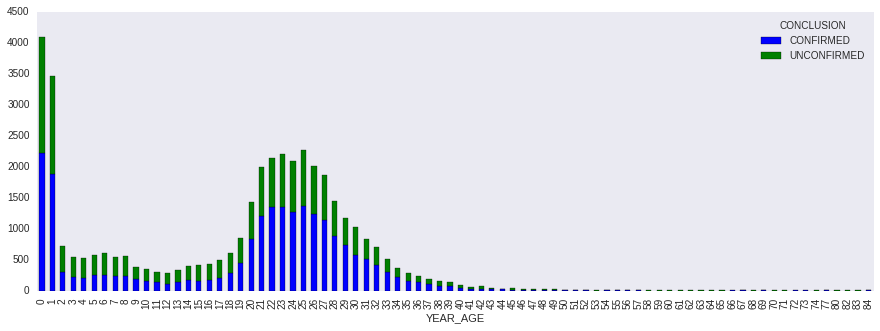

In [21]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [22]:
lab_subset.shape

(39982, 16)

In [24]:
confirmed.sum()

22097

Proportion of lab-confirmed cases older than 20 years

In [25]:
(measles_data[CONFIRMED].YEAR_AGE>20).mean()

0.60257048468117846

In [26]:
age_classes

[0, 5, 10, 15, 20, 25, 30, 35, 40, 100]

In [27]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])
age_groups = age_group.categories
age_groups

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [28]:
#Extract cases by age and time.
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])

In [29]:
age_group.categories

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [30]:
age_slice_endpoints = [g[1:-1].split(',') for g in age_groups]
age_slices = [slice(int(i[0]), int(i[1])) for i in age_slice_endpoints]

In [31]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [32]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [33]:
excludes = ['BOM RETIRO']

In [34]:
N = sp_pop.drop(excludes).ix[unique_districts].sum().drop('Total')

In [35]:
N_age = N.iloc[:8]
N_age.index = age_groups[:-1]
N_age[age_groups[-1]] = N.iloc[8:].sum()
N_age

[0, 5)        844130
[5, 10)       830880
[10, 15)      858750
[15, 20)      904972
[20, 25)      945244
[25, 30)      902086
[30, 35)      835888
[35, 40)      764605
[40, 100)    2841133
dtype: float64

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [36]:
# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = (confirmed_data.groupby(['ONSET', 'AGE_GROUP'])
                    .size()
                    .unstack()
                    .reindex(dates_index)
                    .fillna(0)
                    .sum())

all_confirmed_cases = (confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                       .fillna(0).values.astype(int))

In [37]:
confirmed_counts_2w = (confirmed_data
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W', how='sum'))

In [38]:
# All clinical cases, by district
clinical_counts = (clinic_subset.groupby(['ONSET', 'AGE_GROUP'])
                   .size()
                   .unstack()
                   .reindex(dates_index)
                   .fillna(0)
                   .sum())

all_clinical_cases = (clinical_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                      .fillna(0).values.astype(int))

In [39]:
clinical_counts_2w = (clinic_subset
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W', how='sum'))

In [40]:
age_groups = np.sort(measles_data['AGE_GROUP'].unique())
age_groups

array(['[0, 5)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)', '[5, 10)'], dtype=object)

Check shape of data frame

- 28 bi-monthly intervals, 9 age groups

In [45]:
assert clinical_counts_2w.shape == (28, len(age_groups))

In [46]:
confirmed_counts_2w

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,0,0,0,0,1,0,0,0,0
1997-01-19,0,1,0,0,3,4,0,0,0
1997-02-02,2,1,2,0,2,1,0,0,0
1997-02-16,2,2,0,0,2,1,1,0,0
1997-03-02,3,3,3,2,4,5,1,0,1
1997-03-16,8,6,2,3,12,17,4,0,0
1997-03-30,4,12,5,3,6,5,1,0,0
1997-04-13,8,12,1,1,7,10,3,1,0
1997-04-27,7,11,6,5,23,10,4,0,1


In [47]:
clinical_counts_2w

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,1,3,1,0,0,0,0,0,0
1997-01-19,18,12,4,1,1,3,2,1,0
1997-02-02,12,11,3,2,1,1,1,0,1
1997-02-16,15,8,2,2,2,1,1,0,2
1997-03-02,16,12,3,5,2,2,2,1,0
1997-03-16,26,21,6,10,7,3,3,0,2
1997-03-30,22,15,3,3,3,1,0,1,1
1997-04-13,12,15,1,4,6,3,1,0,2
1997-04-27,14,21,3,4,5,6,2,2,0


In [53]:
obs_date = '1997-06-15'
confirmed_obs_t = confirmed_counts_2w[confirmed_counts_2w.index <= obs_date].values
clinical_obs_t = clinical_counts_2w[clinical_counts_2w.index <= obs_date].values

In [55]:
from pymc3 import Model, sample, find_MAP, Metropolis, NUTS
from pymc3 import (Normal, HalfCauchy, Uniform, MvNormal, Beta, Binomial,
                   Dirichlet, Multinomial, Bernoulli, Poisson, Wishart
                  )
from pymc3 import Potential, Deterministic

import theano.tensor as T

invlogit = T.nnet.sigmoid

confirmation = True
obs_data = '1997-06-15'

with Model() as measles_model:
    
    n_periods, n_age_groups = confirmed_counts_2w.shape
        
    ### Confirmation sub-model
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        p_age = Beta('p_age', 1, 1, shape=n_age_groups)
        p_confirm = p_age[age_index]

        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, observed=confirmed)


    '''
    Truncate data at observation period
    '''  
    obs_index = confirmed_counts_2w.index <= obs_date
    confirmed_obs_t = confirmed_counts_2w[obs_index].values
    clinical_obs_t = clinical_counts_2w[obs_index].values

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = obs_index.sum() - 1

    if confirmation:

        clinical_cases = [Binomial('clinical_cases_%i' % n, i, 
                           p_age, 
                           shape=n_age_groups) for n,i in enumerate(clinical_obs_t)]
        I_age = [Deterministic('I_age_%i' % i, clinical + confirmed_obs_t[i]) 
                               for i,clinical in enumerate(clinical_cases)]
        I = T.stacklists(I_age)

    else:

        I = confirmed_obs_t + clinical_obs_t
        
    # Calcuate age distribution from observed distribution of infecteds to date
    age_dist = Dirichlet('age_dist', np.ones(n_age_groups), 
                         shape=n_age_groups)

    age_dist_like = Potential('age_dist_like', 
                    Multinomial.dist(I.sum(), age_dist).logp(I.sum(0)))

    # Transmission parameter
    beta = Uniform('beta', 1, 50)
        
    # Weakly-informative prior on proportion susceptible being 
    # between 0 and 0.07
    p_susceptible = Beta('p_susceptible', 2, 100)
    
    # Estimated total initial susceptibles
    S_0 = Binomial('S_0', n=N_age.values.astype(int), p=p_susceptible, 
                   shape=n_age_groups)

    S = Deterministic('S', S_0 - I.cumsum(axis=0))

    # Force of infection
    λ = Deterministic('λ', beta * I.sum(1) * S.sum(1) / N_age.sum())

    new_cases = Potential('new_cases', Poisson.dist(λ[:-1]).logp(I.sum(1)[1:]))
    

Applied logodds-transform to p_age and added transformed p_age_logodds to model.
Applied stickbreaking-transform to age_dist and added transformed age_dist_stickbreaking to model.
Applied interval-transform to beta and added transformed beta_interval to model.
Applied logodds-transform to p_susceptible and added transformed p_susceptible_logodds to model.


In [56]:
from theano import config
config.warn.reduce_join = False

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

In [57]:
n_iterations = 50000
n_burn = 40000

June 15, with lab confirmation

In [ ]:
with measles_model:
    trace = sample(n_iterations)

In [ ]:
from pymc3 import traceplot, forestplot

forestplot(trace[n_burn:], vars=['p_age'])

In [ ]:
forestplot(trace[n_burn:], vars=['λ'])

In [ ]:
traceplot(trace[n_burn:], vars=['p_susceptible'])

July 15, with lab confirmation

In [ ]:
model_july = MCMC(model('1997-07-15'), db=db, dbname='model_july')
# model_july.use_step_method(AdaptiveMetropolis, model_july.age_dist)
# model_july.use_step_method(AdaptiveMetropolis, [model_july.beta, model_july.p_susceptible])

In [ ]:
model_july.sample(n_iterations, n_burn)

June 15, no lab confirmation

In [ ]:
model_june_noconf = MCMC(model('1997-06-15', 
                                       confirmation=False), 
                         db=db, dbname='model_june_noconf')
# model_june_noconf.use_step_method(AdaptiveMetropolis, [model_june_noconf.β, model_june_noconf.p_susceptible])
# model_june_noconf.use_step_method(AdaptiveMetropolis, model_june_noconf.age_dist)

In [ ]:
model_june_noconf.sample(n_iterations, n_burn)

July 15, no lab confirmation

In [ ]:
model_july_noconf = MCMC(model('1997-07-15', 
                                       confirmation=False), 
                         db=db, dbname='model_july_noconf')

In [ ]:
model_july_noconf.sample(n_iterations, n_burn)

## Summary of model output

Distance weighting parameter for june model with confirmation

In [ ]:
Matplot.plot(model_june.p_susceptible)

In [ ]:
Matplot.plot(model_june.beta)

Lab confirmation rates, June model

In [ ]:
p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

f, axes = plt.subplots(figsize=(14,6))
sb.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
          color=sb.color_palette("coolwarm", 5)[0],
          order=age_group.categories)
axes.set_ylabel('Confirmation rate')
axes.set_xlabel('Age group')

Proportion of population susceptible, June model.

In [ ]:
Matplot.plot(model_july.beta)

Proportion of population susceptible, June model with no confirmation correction

In [ ]:
Matplot.plot(model_june_noconf.p_susceptible)

Epidemic intensity estimates at June and July, per district.

In [ ]:
Matplot.plot(model_june.lam_t)

In [ ]:
Matplot.plot(model_july.lam_t)

Epidemic intensity for lab- versus clinical-confirmation models

In [ ]:
lam_june = model_june.lam.stats()

fig, axes = plt.subplots(2, 1, sharey=True)

axes[0].plot(lam_june['quantiles'][50].T, 'b-', alpha=0.4)
axes[0].set_ylabel('Epidemic intensity')
axes[0].set_xlabel('time (2-week periods)')
axes[0].set_title('Lab confirmation')

lam_june_noconf = model_june_noconf.lam.stats()

axes[1].plot(lam_june_noconf['quantiles'][50].T, 'b-', alpha=0.4)
axes[1].set_ylabel('Epidemic intensity')
axes[1].set_xlabel('time (2-week periods)')
axes[1].set_title('Clinical confirmation')

plt.tight_layout()

In [ ]:
model_june.S_age.trace()[0]

In [ ]:
S_age_june = pd.DataFrame(model_june.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

In [ ]:
S_age_june = pd.DataFrame(model_june.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)

In [ ]:
S_age_july = pd.DataFrame(model_july.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)

Numbers of suscepibles in each age group, under lab vs clinical confirmation

In [ ]:
g = sb.factorplot("Age", "S", "Confirmation", S_age_june, kind="box",
                   palette="hls", size=6, aspect=2, linewidth=0.3, fliersize=0, 
                  order=age_group.categories)
g.despine(offset=10, trim=True)
g.set_axis_labels("Age Group", "Susceptibles");

In [ ]:
june_lam = pd.DataFrame(model_june.lam_t.trace()).unstack().reset_index()
june_lam.columns = ('district', 'iteration', 'λ')
june_lam['month'] = 'June'

In [ ]:
june_lam_noconf = pd.DataFrame(model_june_noconf.lam_t.trace()).unstack().reset_index()
june_lam_noconf.columns = ('district', 'iteration', 'λ')
june_lam_noconf['month'] = 'June'

In [ ]:
july_lam = pd.DataFrame(model_july.lam_t.trace()).unstack().reset_index()
july_lam.columns = ('district', 'iteration', 'λ')
july_lam['month'] = 'July'

In [ ]:
july_lam_noconf = pd.DataFrame(model_july_noconf.lam_t.trace()).unstack().reset_index()
july_lam_noconf.columns = ('district', 'iteration', 'λ')
july_lam_noconf['month'] = 'July'

In [ ]:
confirmed_lam = june_lam.append(july_lam, ignore_index=True)

In [ ]:
june_means = june_lam.groupby('district')['λ'].mean()
june_means.sort(ascending=False)

In [ ]:
july_means = july_lam.groupby('district')['λ'].mean()
july_means.sort(ascending=False)

In [ ]:
sorted_districts = june_means.index.values

Epidemic intensity by district in June and July (with lab confirmation), sorted by June means.

In [ ]:
sb.set_context("talk", font_scale=0.8)

f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=june_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('June')
ax_1.set_title(r'Epidemic intensity (λ) estimates, ordered by June means')

sb.boxplot('district', 'λ', data=july_lam, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dashed', linewidth=0.2)
ax_2.set_xticks([])
ax_2.set_ylabel('July')

f.tight_layout()

Epidemic intensity by district in June for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

In [ ]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=june_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
ax_1.set_title(r'June epidemic intensity (λ) estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'λ', data=june_lam_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=june_means.index.values)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

Epidemic intensity by district in July for lab-confirmed and clinical-confirmed, sorted by lab-confirmed means.

In [ ]:
july_means = july_lam.groupby('district')['λ'].mean()
july_means.sort(ascending=False)

In [ ]:
f, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(12,6), sharey=True, sharex=True)

sb.boxplot('district', 'λ', data=july_lam, ax=ax_1, linewidth=0.5, 
           fliersize=0, color='r', order=july_means.index.values)
# ax_1.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_1.set_xticks([])
ax_1.set_xlabel('')
ax_1.set_ylabel('Lab')
# ax_1.set_yticks(np.arange(13, step=2))
ax_1.set_title(r'July epidemic intensity (λ) estimates, ordered by lab-confirmed means')

sb.boxplot('district', 'λ', data=july_lam_noconf, ax=ax_2, linewidth=0.5, 
           fliersize=0, color='r', order=sorted_districts)
# ax_2.hlines(1, xmin=0, xmax=93, linestyles='dotted', linewidth=0.75)
ax_2.set_xticks([])
ax_2.set_ylabel('Clinical')

f.tight_layout()

In [ ]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

In [ ]:
june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [ ]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

In [ ]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

In [ ]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

In [ ]:
axes = sb.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sb.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sb.despine(offset=10, trim=True)

In [ ]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])

In [ ]:
Matplot.summary_plot(model_june.p_age)

## Mapping spatial effects

In [ ]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

lllat=-24
urlat=-23.3
lllon=-47
urlon=-46.3

SP_base = Basemap(ax=None, lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, 
                  resolution='i',
                 epsg='4326')

In [ ]:
SP_dist = gpd.GeoDataFrame.from_file('Sao Paulo/Brazil_full/BRA_adm3.shp').to_crs({'proj': 'longlat', 
                                                                               'ellps': 'WGS84', 
                                                                               'datum': 'WGS84'})

In [ ]:
SP_dist['DIST_NAME'] = [trans.trans(_).upper() for _ in SP_dist.NAME_3]

In [ ]:
λ_june = pd.Series(model_june.λ_t.stats()['mean'], index=sp_districts)

In [ ]:
λ_june

In [ ]:
SP_dist_merged = SP_dist.merge(pd.DataFrame(λ_june, columns=['λ']), left_on='DIST_NAME', right_index=True)

In [ ]:
measles_onset_conf = measles_data[CONFIRMED].groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0).sum()

In [ ]:
measles_onset_conf

In [ ]:
_rates = measles_onset_conf/sp_pop.sum(1)

In [ ]:
SP_dist_conf = SP_dist.merge(pd.DataFrame(_rates, columns=['rate']), left_on='DIST_NAME', right_index=True)

Estimated expected value for infecteds, by district

In [ ]:
from matplotlib.pyplot import cm

map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist_merged.plot(column='λ', colormap=cm.Reds, axes=map_ax)

Observed confirmed cases, by district

In [ ]:
map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist_conf.plot(column='rate', colormap=cm.Reds, axes=map_ax)